In [2]:
import re
import nltk
import string
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

# Ensure the results directory exists
if not os.path.exists('./results'):
    os.makedirs('./results')
    os.makedirs('./results/fakerecogna_dataset')
    os.makedirs('./results/llm_dataset')

if not os.path.exists('./dataset'):
    os.makedirs('./dataset')
    os.makedirs('./dataset/fakerecogna_dataset')
    os.makedirs('./dataset/llm_dataset')

# Ensure the results directory exists
if not os.path.exists('./models'):
    os.makedirs('./models')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [3]:
# Constants
VECTOR_FILEPATH = './models/tfidf_vectorizer.joblib'

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('portuguese'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = RSLPStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Function to load and preprocess data from a CSV file
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, encoding='latin1')
    df = df.drop_duplicates(subset='news').copy()
    df = df[df['news'].apply(lambda x: isinstance(x, str) and pd.notnull(x))].copy()
    df['news'] = df['news'].apply(preprocess_text)
    return df

# Function to split data into training and testing sets
def split_data(df):
    df_copy = df.copy()
    X = df_copy['news']
    y = df_copy['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    common_samples = set(X_train).intersection(set(X_test))
    print(f"Number of common samples between train and test sets: {len(common_samples)}")
    return X_train, X_test, y_train, y_test

# Vectorize text data
def vectorize_data(X_train, X_test, vectorizer_filepath):
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    joblib.dump(vectorizer, vectorizer_filepath)
    return X_train_tfidf, X_test_tfidf

# Function to resample training data using SMOTE if class imbalance exceeds the threshold of 20%
def resample_data(X_train_tfidf, y_train, imbalance_threshold=0.2):
    # Calculate class distribution
    class_distribution = Counter(y_train)
    total_samples = len(y_train)

    # Calculate the percentage of the minority class
    minority_class_percentage = min(class_distribution.values()) / total_samples

    # Check if SMOTE is needed
    if minority_class_percentage < imbalance_threshold:
        print(f"Applying SMOTE. Minority class percentage: {minority_class_percentage:.2%}")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
        return X_train_resampled, y_train_resampled
    else:
        print(f"SMOTE not needed. Minority class percentage: {minority_class_percentage:.2%}")
        return X_train_tfidf, y_train

# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, title, save_path=None):
      cm = confusion_matrix(y_test, y_pred)

      print(f"Confusion Matrix - {title}:")
      print(cm)

      plt.figure(figsize=(10, 7))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.title(f'Confusion Matrix - {title}')
      if save_path:
          plt.savefig(save_path)
      plt.show()

# Function to plot performance metrics of a model
def plot_performance_metrics(model_names, accuracies, precisions, recalls, f1_scores, save_path=None):
    x = np.arange(len(model_names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.bar(x - 1.5*width, accuracies, width, label='Accuracy')
    ax.bar(x - 0.5*width, precisions, width, label='Precision')
    ax.bar(x + 0.5*width, recalls, width, label='Recall')
    ax.bar(x + 1.5*width, f1_scores, width, label='F1 Score')

    ax.set_xlabel('Model')
    ax.set_ylabel('Scores')
    ax.set_title('Performance of Different Models')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    fig.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Function to print performance metrics
def print_performance_metrics(model_name, y_test, y_pred, accuracy, precision, recall, f1, roc_auc=None):
    print(f"Performance of {model_name}:")
    report = classification_report(y_test, y_pred)
    print(report)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc}")
    print()

def plot_roc_curves(model_names, X_test, y_test, save_path=None):
    plt.figure(figsize=(10, 7))
    model_loaded = False  # Flag to check if any model is successfully loaded

    for model_name in model_names:
        try:
            print(model_name.replace(" ", "_").lower())
            # Load the saved model
            model = joblib.load(f'./models/{model_name.replace(" ", "_").lower()}.joblib')

            if hasattr(model, 'predict_proba'):
                y_proba = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, 'decision_function'):
                y_proba = model.decision_function(X_test)
            else:
                print(f"{model_name} does not support predict_proba or decision_function.")
                continue

            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
            model_loaded = True  # Successfully loaded and evaluated a model

        except Exception as e:
            print(f"Error loading or evaluating {model_name}: {e}")

    if model_loaded:
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")

        if save_path:
            plt.savefig(save_path)
        plt.show()
    else:
        print("No models were successfully loaded or evaluated. No plot to display.")

def plot_calibration_curve(model_names, X_test, y_test, save_path=None):
    plt.figure(figsize=(10, 7))
    for model_name in model_names:
        try:
            # Load the saved model
            model = joblib.load(f'./models/{model_name.replace(" ", "_").lower()}.joblib')

            if hasattr(model, 'predict_proba'):
                y_proba = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, 'decision_function'):
                y_proba = model.decision_function(X_test)
            else:
                continue

            prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
            plt.plot(prob_pred, prob_true, marker='o', label=model_name)

        except Exception as e:
            print(f"Error loading or evaluating {model_name}: {e}")

    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')

    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_class_balance(df):
    # Get the count of each class
    class_counts = df['class'].value_counts()

    # Mapping for class labels
    class_labels = {0: 'Fake News (0)', 1: 'Real News (1)'}

    # Prepare labels and values for plotting
    labels = [class_labels.get(cls, f'Class {cls}') for cls in class_counts.index]
    values = class_counts.values

    # Plotting the class distribution
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'orange'][:len(class_counts)])
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(rotation=0)
    plt.show()

    # Print the exact numbers
    print("Class Distribution:")
    for cls, count in class_counts.items():
        label = class_labels.get(cls, f'Class {cls}')
        print(f"{label}: {count} samples")

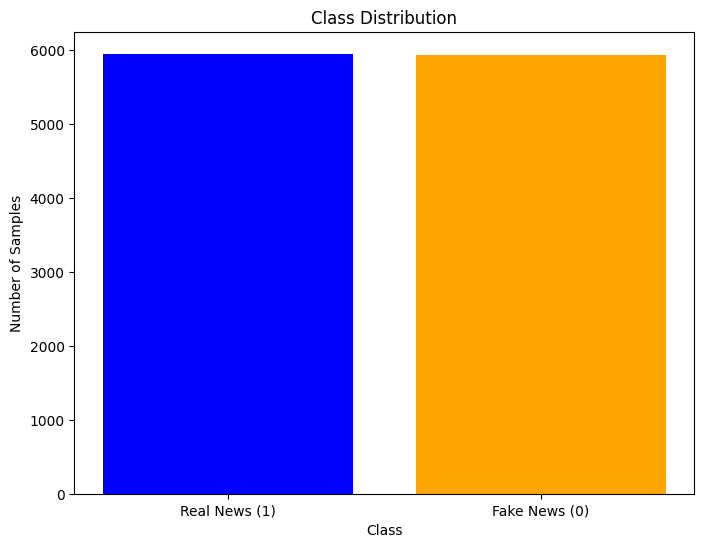

Class Distribution:
Real News (1): 5951 samples
Fake News (0): 5935 samples


In [4]:
filepath_fakerecogna = './dataset/fakerecogna_dataset/fakerecogna_processed.csv'
df = load_and_preprocess_data(filepath_fakerecogna)
plot_class_balance(df)

In [5]:
X_train, X_test, y_train, y_test = split_data(df)
X_train_tfidf, X_test_tfidf = vectorize_data(X_train, X_test, VECTOR_FILEPATH)
X_train_resampled, y_train_resampled = resample_data(X_train_tfidf, y_train)

Number of common samples between train and test sets: 0
SMOTE not needed. Minority class percentage: 49.94%


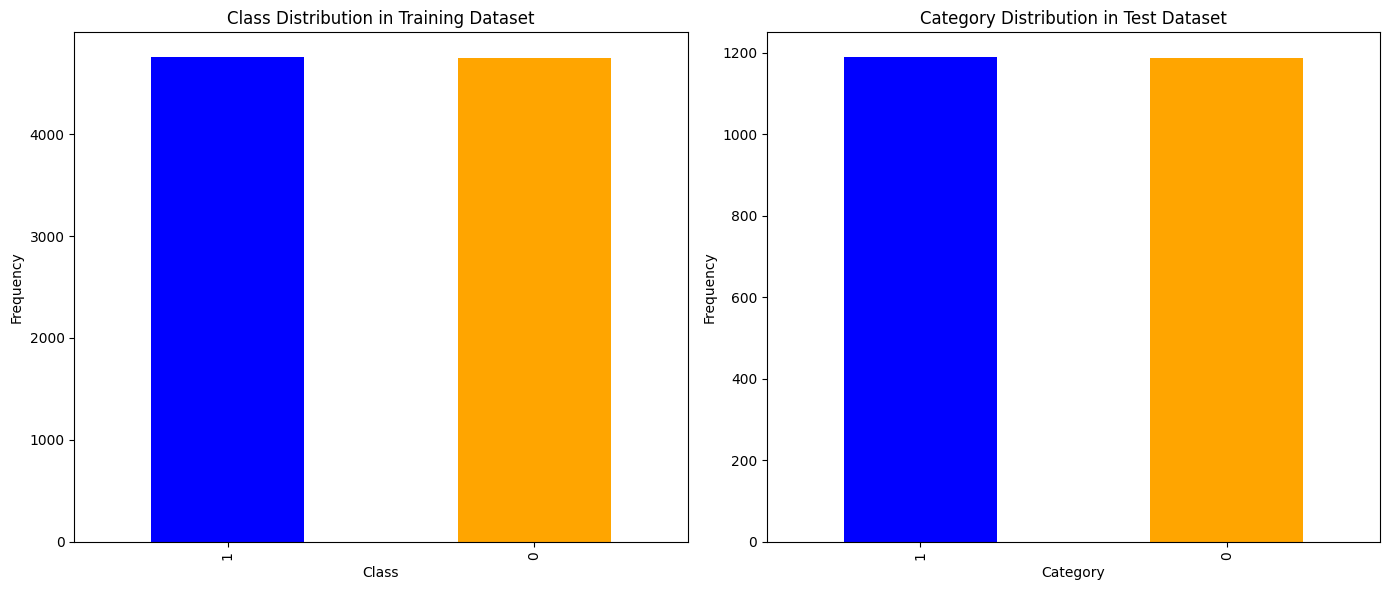

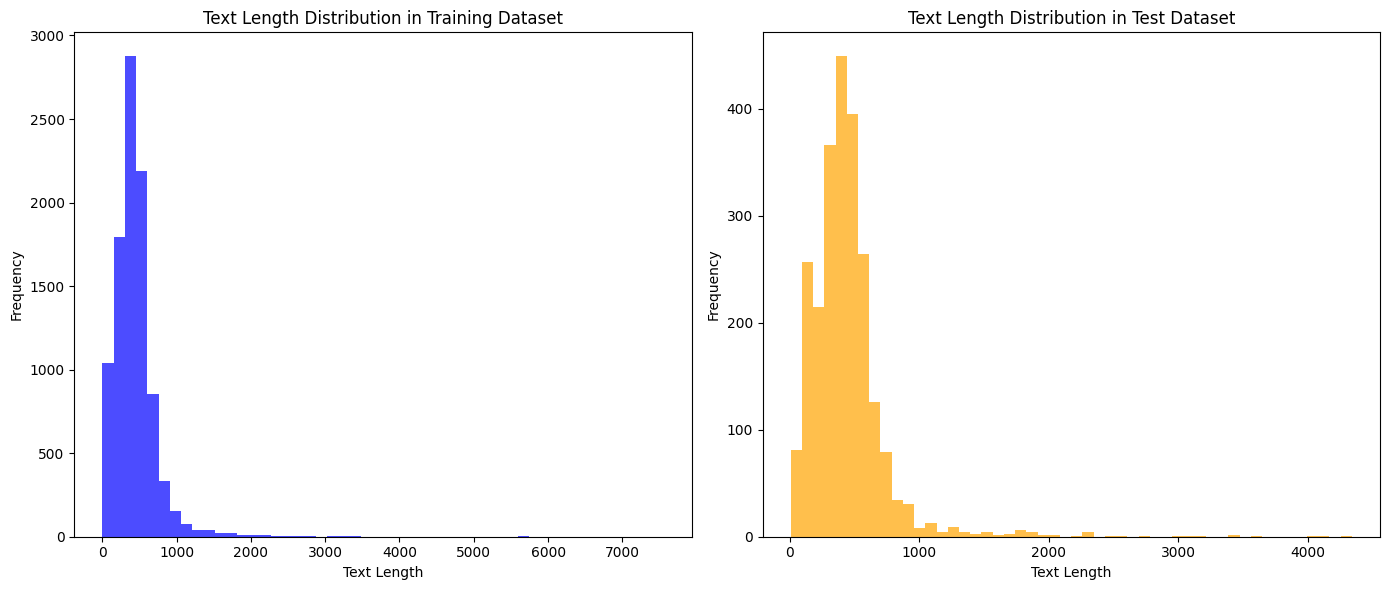

(class
 1    4760
 0    4748
 Name: count, dtype: int64,
 count    9508.000000
 mean      445.160181
 std       344.919650
 min         2.000000
 25%       272.000000
 50%       406.000000
 75%       538.000000
 max      7558.000000
 Name: news, dtype: float64,
 class
 1    1191
 0    1187
 Name: count, dtype: int64,
 count    2378.000000
 mean      445.800252
 std       336.022344
 min         7.000000
 25%       282.000000
 50%       408.500000
 75%       535.000000
 max      4343.000000
 Name: news, dtype: float64)

In [6]:
# Class distribution in the training dataset
train_class_distribution = y_train.value_counts()

# Text length distribution in the training dataset before being vectorized
train_text_lengths = X_train.str.len()

# Class distribution in the test dataset
test_class_distribution = y_test.value_counts()

# Text length distribution in the test dataset before being vectorized
test_text_lengths = X_test.str.len()

# Plotting class distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
train_class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
test_class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Category Distribution in Test Dataset')
plt.xlabel('Category')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plotting text length distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(train_text_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Text Length Distribution in Training Dataset')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_text_lengths, bins=50, color='orange', alpha=0.7)
plt.title('Text Length Distribution in Test Dataset')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

train_class_distribution, train_text_lengths.describe(), test_class_distribution, test_text_lengths.describe()

In [7]:
# Initialize models and parameter grids
MODELS = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(max_iter=300)
}

PARAM_GRIDS = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'Neural Network': {'hidden_layer_sizes': [(100,), (100, 50)], 'activation': ['relu', 'tanh']}
}

Training Logistic Regression...
Performance of Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1187
           1       0.93      0.94      0.94      1191

    accuracy                           0.94      2378
   macro avg       0.94      0.94      0.94      2378
weighted avg       0.94      0.94      0.94      2378

Accuracy: 0.9356602186711522
Precision: 0.9339464882943144
Recall: 0.9378673383711167
F1 Score: 0.9359028068705488
ROC-AUC: 0.9807634767071486

Confusion Matrix - Logistic Regression:
[[1108   79]
 [  74 1117]]


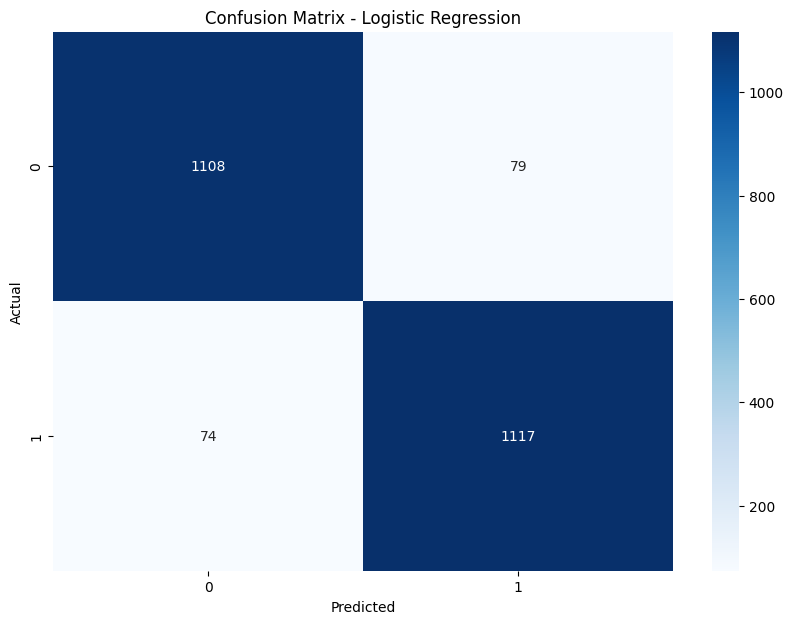

Training Support Vector Machine...
Performance of Support Vector Machine:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1187
           1       0.94      0.94      0.94      1191

    accuracy                           0.94      2378
   macro avg       0.94      0.94      0.94      2378
weighted avg       0.94      0.94      0.94      2378

Accuracy: 0.93986543313709
Precision: 0.9381270903010034
Recall: 0.9420654911838791
F1 Score: 0.9400921658986175
ROC-AUC: 0.9828084404445868

Confusion Matrix - Support Vector Machine:
[[1113   74]
 [  69 1122]]


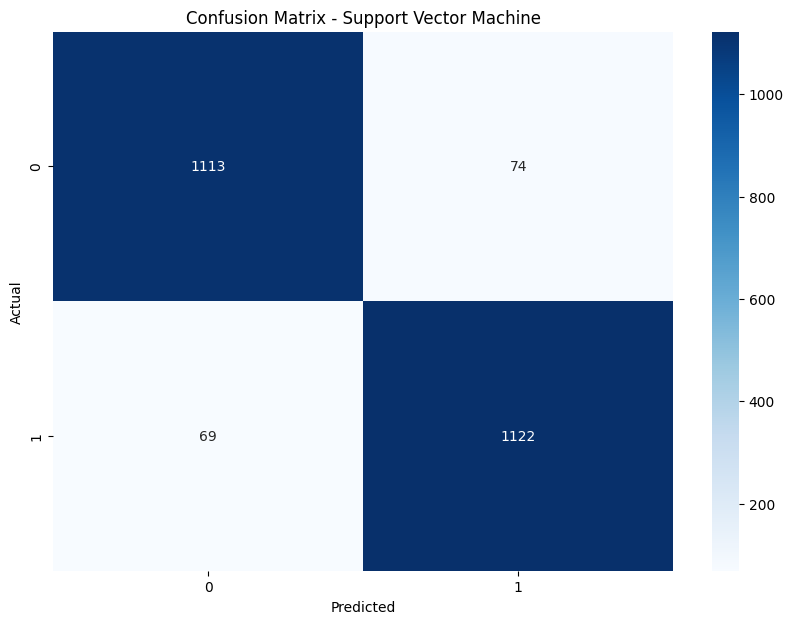

Training Random Forest...
Performance of Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1187
           1       0.93      0.92      0.93      1191

    accuracy                           0.93      2378
   macro avg       0.93      0.93      0.93      2378
weighted avg       0.93      0.93      0.93      2378

Accuracy: 0.9276703111858705
Precision: 0.9328802039082413
Recall: 0.9219143576826196
F1 Score: 0.9273648648648649
ROC-AUC: 0.9757012895791731

Confusion Matrix - Random Forest:
[[1108   79]
 [  93 1098]]


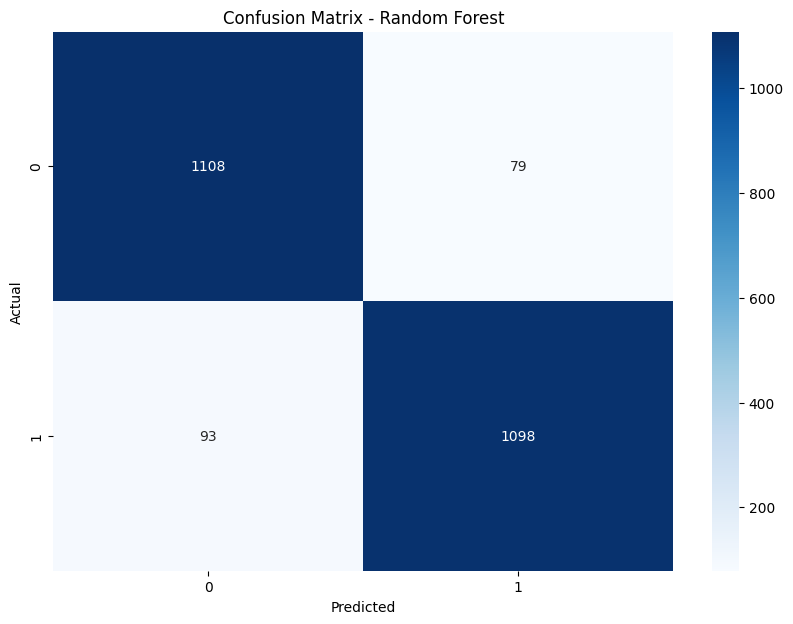

Training Neural Network...
Performance of Neural Network:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1187
           1       0.93      0.92      0.93      1191

    accuracy                           0.93      2378
   macro avg       0.93      0.93      0.93      2378
weighted avg       0.93      0.93      0.93      2378

Accuracy: 0.9255677039529016
Precision: 0.9289340101522843
Recall: 0.9219143576826196
F1 Score: 0.9254108723135273
ROC-AUC: 0.9740874588054045

Confusion Matrix - Neural Network:
[[1103   84]
 [  93 1098]]


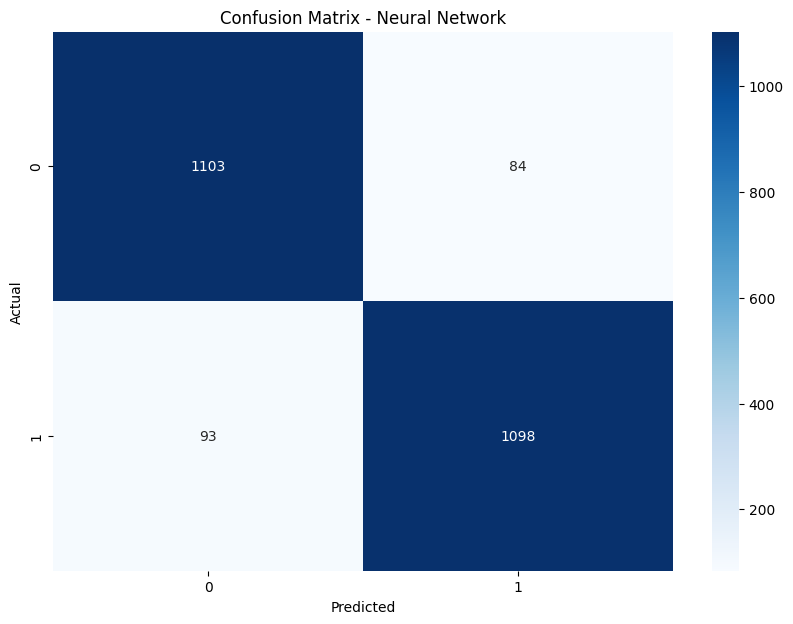

In [8]:
# Train and test models on FakeRecogna dataset

# This is to ignore the warnings that would be thrown when printing the Confusion Matrix
# The warning happens because this dataset has all entries with class=0(fake news)
warnings.simplefilter("ignore", category=UndefinedMetricWarning)

# Custom scorer for recall of the fake news class (0);
real_news_precision_scorer = make_scorer(precision_score, pos_label=1)

def train_and_evaluate(models, param_grids, X_train_resampled, y_train_resampled, X_test_tfidf, y_test):
    model_names, accuracies, precisions, recalls, f1_scores, roc_aucs, cv_results = [], [], [], [], [], [], []
    best_hyperparameters = {}
    hyperparameters_file_path = './results/fakerecogna_dataset/best_hyperparameters.json'

    for model_name, model in models.items():
        try:
            print(f"Training {model_name}...")
            grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring=real_news_precision_scorer)
            grid_search.fit(X_train_resampled, y_train_resampled)
            best_model = grid_search.best_estimator_
            best_hyperparameters[model_name] = grid_search.best_params_
            y_pred = best_model.predict(X_test_tfidf)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            recall = recall_score(y_test, y_pred, zero_division=1)
            f1 = f1_score(y_test, y_pred, zero_division=1)

            # Check if the model supports predict_proba or decision_function
            if hasattr(best_model, 'decision_function'):
                y_scores = best_model.decision_function(X_test_tfidf)
            else:
                y_scores = best_model.predict_proba(X_test_tfidf)[:, 1]

            roc_auc = roc_auc_score(y_test, y_scores)

            model_names.append(model_name)
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            roc_aucs.append(roc_auc)
            cv_results.append({
                'model_name': model_name,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })

            print_performance_metrics(model_name, y_test, y_pred, accuracy, precision, recall, f1, roc_auc)

            confusion_matrix_path = f'./results/fakerecogna_dataset/confusion_matrix_fakerecogna_dataset_{model_name.replace(" ", "_").lower()}.png'
            plot_confusion_matrix(y_test, y_pred, model_name, save_path=confusion_matrix_path)

            joblib.dump(best_model, f'models/{model_name.replace(" ", "_").lower()}.joblib')

        except Exception as e:
            print(f"Error training {model_name}: {e}")

    with open(hyperparameters_file_path, 'w') as f:
        json.dump(best_hyperparameters, f, indent=4)

    return model_names, accuracies, precisions, recalls, f1_scores, roc_aucs, cv_results

model_names, accuracies, precisions, recalls, f1_scores, roc_aucs, cv_results = train_and_evaluate(
    MODELS, PARAM_GRIDS, X_train_resampled, y_train_resampled, X_test_tfidf, y_test)


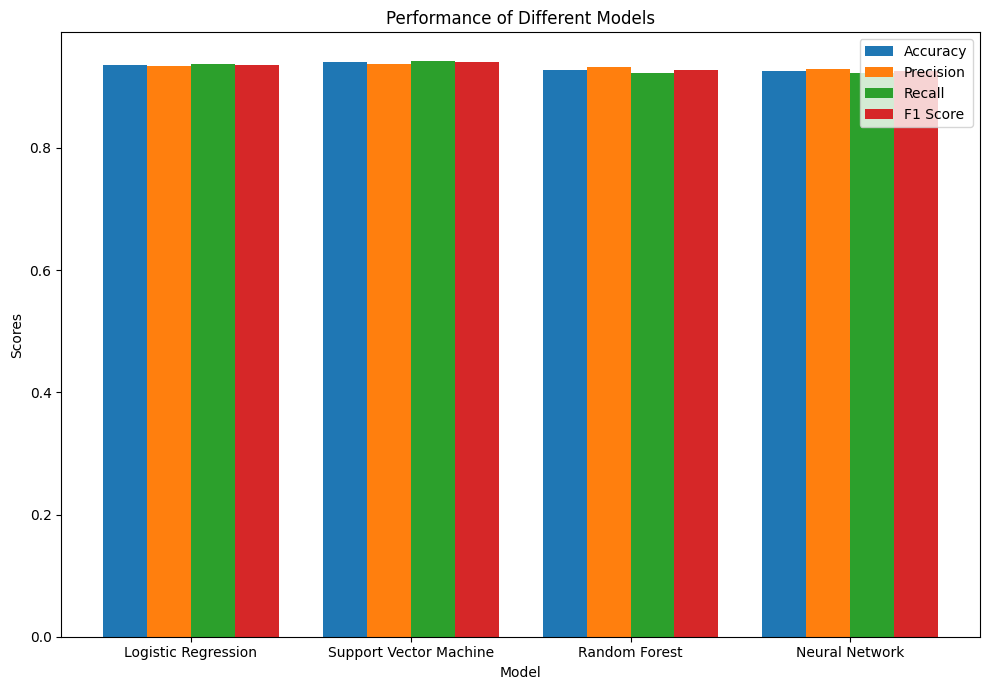

In [9]:
# Plot and save performance metrics
performance_metrics_path = './results/fakerecogna_dataset/performance_metrics_fakerecogna_dataset.png'
plot_performance_metrics(model_names, accuracies, precisions, recalls, f1_scores, save_path=performance_metrics_path)

logistic_regression
support_vector_machine
random_forest
neural_network


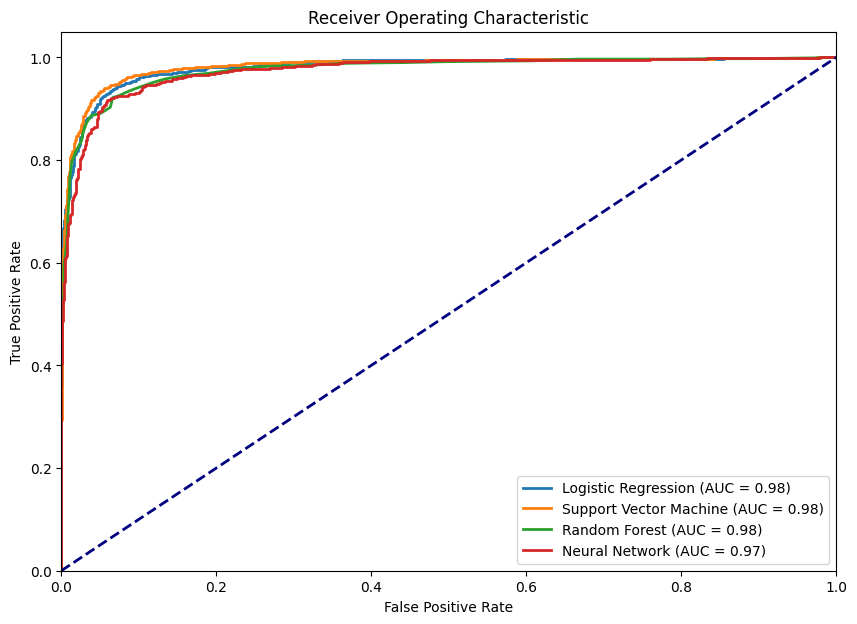

In [10]:
# Plot ROC curves
roc_curves_path = './results/fakerecogna_dataset/roc_curves_fakerecogna_dataset.png'
plot_roc_curves(MODELS, X_test_tfidf, y_test, save_path=roc_curves_path)

Error loading or evaluating Support Vector Machine: y_prob has values outside [0, 1].


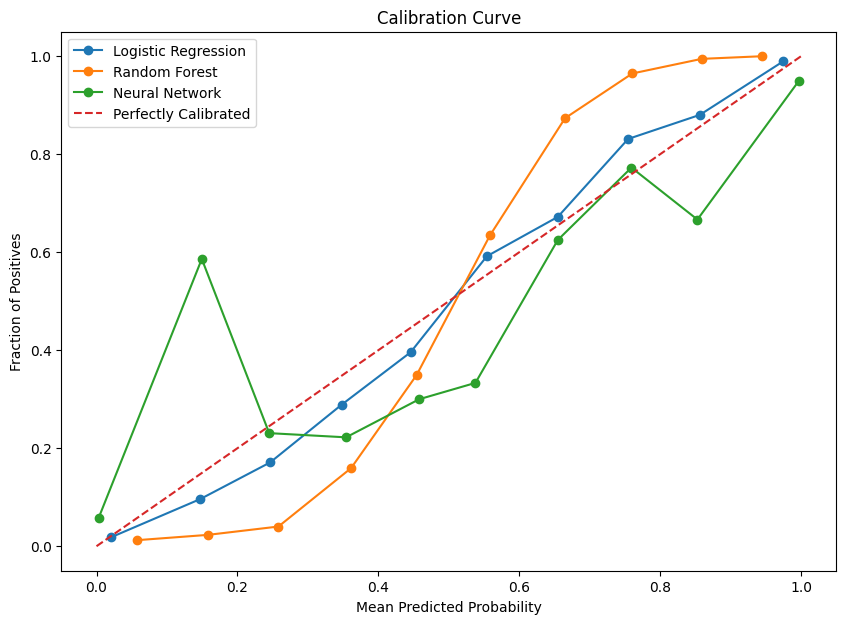

In [11]:
# Plot calibration curves
calibration_curve_path = './results/fakerecogna_dataset/calibration_curve_fakerecogna_dataset.png'
plot_calibration_curve(MODELS, X_test_tfidf, y_test, save_path=calibration_curve_path)

# Test the models trained with fakerecogna_dataset.csv against a dataset entirely composed of fake news generated by Llama-3-8B-instruct. All entries in this dataset are fake news(class = 0)

In [12]:
llama_fake_news_test_data_path = './dataset/llm_dataset/fake_news_llama_3_8b_instruct_processed.csv'
llama_fake_news_test_data = load_and_preprocess_data(llama_fake_news_test_data_path)

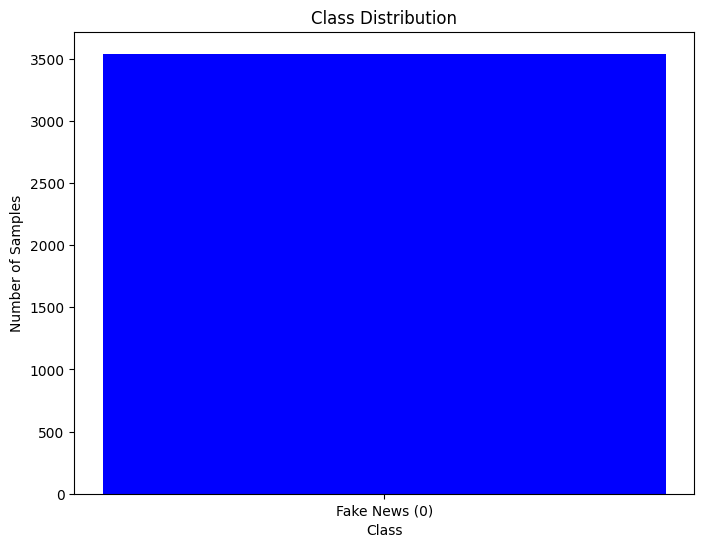

Class Distribution:
Fake News (0): 3540 samples


In [13]:
plot_class_balance(llama_fake_news_test_data)

In [14]:
# Vectorize the new text data using the saved vectorizer
vectorizer = joblib.load(VECTOR_FILEPATH)
X_new_tfidf = vectorizer.transform(llama_fake_news_test_data['news'])
y_test = llama_fake_news_test_data['class']

Performance of Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.05      0.09      3540
           1       0.00      0.00      0.00         0

    accuracy                           0.05      3540
   macro avg       0.50      0.02      0.05      3540
weighted avg       1.00      0.05      0.09      3540

Accuracy: 0.04745762711864407
Precision: 0.0
Recall: 1.0
F1 Score: 0.0

Confusion Matrix - Logistic Regression:
[[ 168 3372]
 [   0    0]]


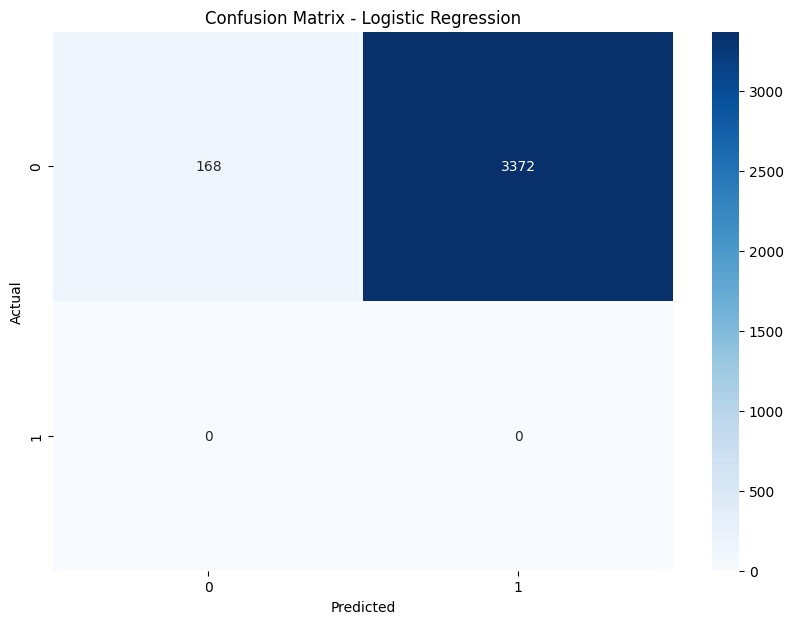

Performance of Support Vector Machine:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08      3540
           1       0.00      0.00      0.00         0

    accuracy                           0.04      3540
   macro avg       0.50      0.02      0.04      3540
weighted avg       1.00      0.04      0.08      3540

Accuracy: 0.044350282485875706
Precision: 0.0
Recall: 1.0
F1 Score: 0.0

Confusion Matrix - Support Vector Machine:
[[ 157 3383]
 [   0    0]]


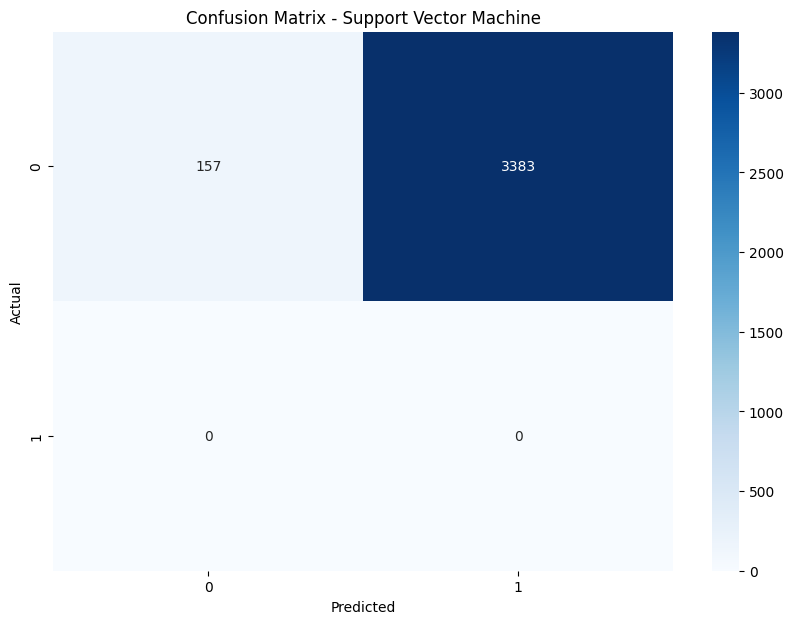

Performance of Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.13      0.23      3540
           1       0.00      0.00      0.00         0

    accuracy                           0.13      3540
   macro avg       0.50      0.07      0.12      3540
weighted avg       1.00      0.13      0.23      3540

Accuracy: 0.13192090395480227
Precision: 0.0
Recall: 1.0
F1 Score: 0.0

Confusion Matrix - Random Forest:
[[ 467 3073]
 [   0    0]]


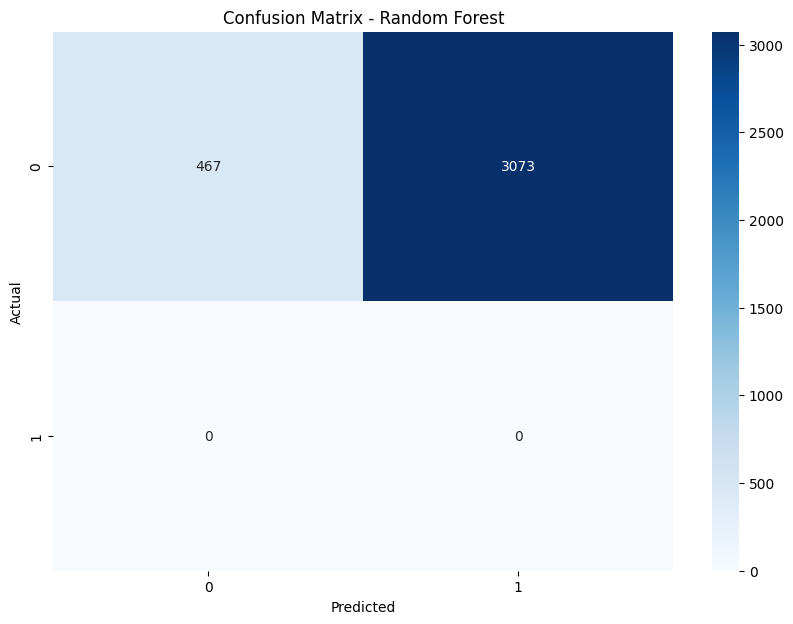

Performance of Neural Network:
              precision    recall  f1-score   support

           0       1.00      0.05      0.09      3540
           1       0.00      0.00      0.00         0

    accuracy                           0.05      3540
   macro avg       0.50      0.02      0.05      3540
weighted avg       1.00      0.05      0.09      3540

Accuracy: 0.04745762711864407
Precision: 0.0
Recall: 1.0
F1 Score: 0.0

Confusion Matrix - Neural Network:
[[ 168 3372]
 [   0    0]]


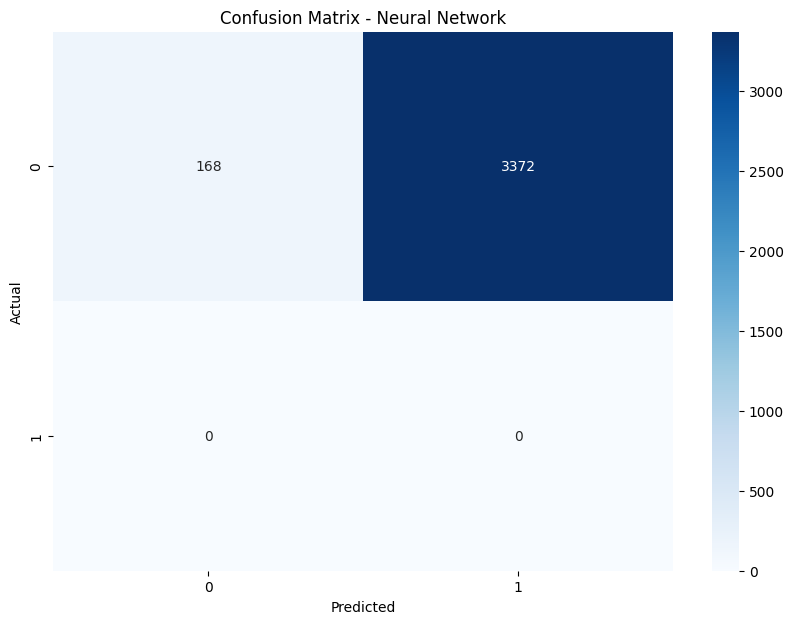

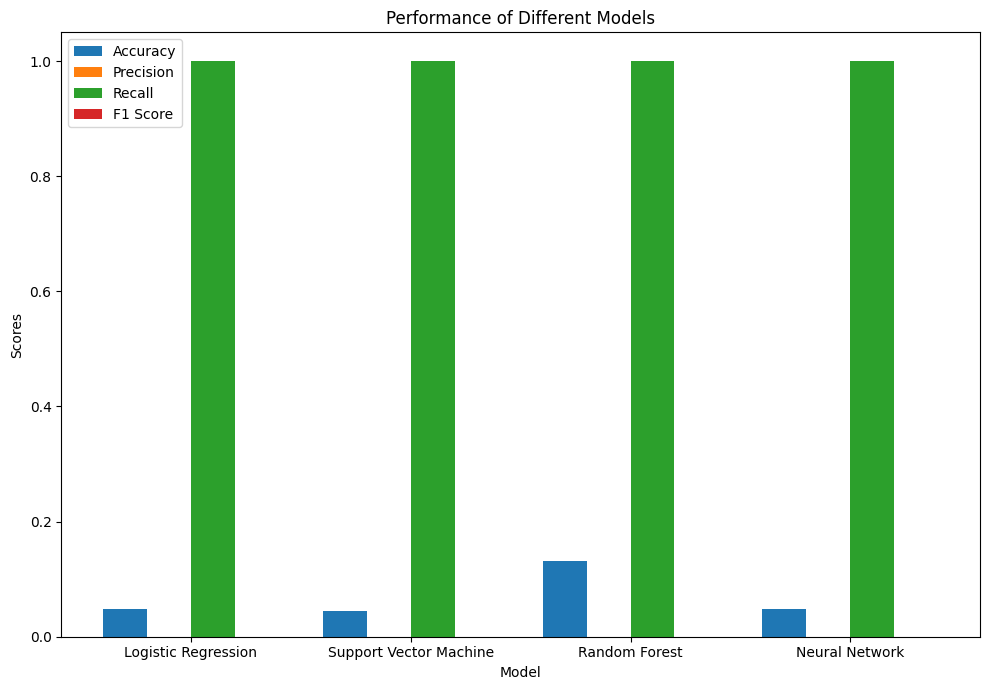

In [15]:
# Initialize lists to store performance metrics
model_names = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

for model_name in MODELS:
  try:
      # Load the model
      model = joblib.load(f'./models/{model_name.replace(" ", "_").lower()}.joblib')

      # Predict the results
      y_pred = model.predict(X_new_tfidf)

      # Add predictions to the dataframe
      llama_fake_news_test_data[f'prediction_{model_name.replace(" ", "_").lower()}'] = y_pred

      # Evaluate the performance
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, zero_division=1)
      recall = recall_score(y_test, y_pred, zero_division=1)
      f1 = f1_score(y_test, y_pred, zero_division=1)

      # Store the results
      model_names.append(model_name)
      accuracies.append(accuracy)
      precisions.append(precision)
      recalls.append(recall)
      f1_scores.append(f1)

      print_performance_metrics(model_name, y_test, y_pred, accuracy, precision, recall, f1)

      # Plot confusion matrix
      confusion_matrix_path = f'./results/llm_dataset/confusion_matrix_llm_test_dataset_{model_name.replace(" ", "_").lower()}.png'
      plot_confusion_matrix(y_test, y_pred, model_name, save_path=confusion_matrix_path)

  except Exception as e:
      print(f"Error loading and predicting with {model_name}: {e}")

# Save the performance metrics to a CSV file
performance_metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})
performance_metrics_df.to_csv('./results/llm_dataset/performance_metrics_llm_test_dataset.csv', index=False)

# Plot the performance metrics
performance_metrics_llm_dataset_path = './results/llm_dataset/performance_metrics_llm_test_dataset.png'
plot_performance_metrics(model_names, accuracies, precisions, recalls, f1_scores, save_path=performance_metrics_llm_dataset_path)

In [16]:
# Save the results to a predictions.csv file
output_filepath = './results/llm_dataset/prediction_llm_test_dataset.csv'
llama_fake_news_test_data.to_csv(output_filepath, index=False)

In [17]:
import shutil
import os
from google.colab import files

# Define the directory and output zip file name
fakerecogna = './results/fakerecogna_dataset'
output_filename = 'result_fakerecogna_dataset.zip'

# Zip the directory
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', fakerecogna)

# Download the zip file
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Define the directory and output zip file name
llm = './results/llm_dataset'
output_filename = 'result_llm_dataset.zip'

# Zip the directory
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', llm)

# Download the zip file
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>